In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Caminho para o dataset
dataset_path = r"D:\libras-mask-pose"

# Parâmetros globais
num_frames = 30
altura, largura, canais = 64, 64, 1

# Dicionário de classes
label_dict = {label_dir: idx for idx, label_dir in enumerate(os.listdir(dataset_path))}
print(f"Label Dictionary: {label_dict}")

Label Dictionary: {'Acontecer': 0, 'Amarelo': 1, 'America': 2, 'Aproveitar': 3, 'Banheiro': 4, 'Barulho': 5, 'Cinco': 6, 'Espelho': 7, 'Esquina': 8, 'Medo': 9}


In [4]:
# Função de processamento de vídeos
def process_video(video_path, target_frames=num_frames):
    cap = cv2.VideoCapture(video_path)
    frames = []
    success, frame = cap.read()
    
    # Loop para leitura dos frames
    while success:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        resized_frame = cv2.resize(gray_frame, (largura, altura))
        frames.append(resized_frame / 255.0)  # Normalização entre 0 e 1
        success, frame = cap.read()
    
    cap.release()
    
    # Normalizaação do número de frames ( padding ou truncamento )
    if len(frames) > target_frames: # Truncamento
        indices = np.linspace(0, len(frames) - 1, target_frames).astype(int)
        frames = [frames[i] for i in indices]
    elif len(frames) < target_frames: # Padding
        padding = target_frames - len(frames)
        frames.extend([frames[-1]] * padding)
    
    return np.array(frames)

In [ ]:
# Listas para armazenar os dados e labels
data, labels = [], []

# Carregar os dados
for label_dir in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, label_dir)
    if os.path.isdir(class_path):
        for video_file in os.listdir(class_path):
            if video_file.endswith('.mp4'):
                video_path = os.path.join(class_path, video_file)
                data.append(process_video(video_path))
                labels.append(label_dict[label_dir])

data = np.array(data).reshape(-1, num_frames, altura, largura, canais)
labels = np.array(labels)

In [5]:
num_classes = len(label_dict)
print(f"Number of classes: {num_classes}")

Number of classes: 10


In [ ]:
# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, stratify=labels, random_state=42)

# Codificar labels
num_classes = len(label_dict)
y_train_hot = to_categorical(y_train, num_classes=num_classes)
y_test_hot = to_categorical(y_test, num_classes=num_classes)


In [29]:
# Construção do modelo
def build_3d_cnn(input_shape=(num_frames, altura, largura, canais), num_classes=num_classes):
    model = models.Sequential([
        layers.Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling3D((2, 2, 2)),
        layers.Conv3D(64, (3, 3, 3), activation='relu'),
        layers.MaxPooling3D((2, 2, 2)),
        layers.Conv3D(128, (3, 3, 3), activation='relu'),
        layers.GlobalAveragePooling3D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Compilação
model = build_3d_cnn()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 28, 62, 62, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 14, 31, 31, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 12, 29, 29, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 6, 14, 14, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 12, 12, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295,370 (1.13 MB)

 Trainable params: 295,370 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Treinamento
history = model.fit(X_train, y_train_hot, batch_size=8, epochs=40, validation_split=0.2)

Epoch 1/40
194/194 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - accuracy: 0.9052 - loss: 0.2620 - val_accuracy: 0.9457 - val_loss: 0.1687
Epoch 2/40
194/194 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.9238 - loss: 0.2079 - val_accuracy: 0.9302 - val_loss: 0.1896
Epoch 3/40
194/194 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.9154 - loss: 0.2188 - val_accuracy: 0.9406 - val_loss: 0.1744
Epoch 4/40
194/194 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.9184 - loss: 0.2282 - val_accuracy: 0.9380 - val_loss: 0.1605
Epoch 5/40
194/194 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.9202 - loss: 0.1970 - val_accuracy: 0.9509 - val_loss: 0.1389
Epoch 6/40
194/194 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.9453 - loss: 0.1585 - val_accuracy: 0.9328 - val_loss: 0.1643
Epoch 7/40
194/194 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.9386 - loss: 0.1679 - val_accuracy: 0.9432 - val_loss: 0.1591
Epoch 8/40
194/194 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.9459 - loss: 0

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9925 - loss: 0.0182
Test Loss: 0.02220563404262066, Test Accuracy: 0.9906976819038391


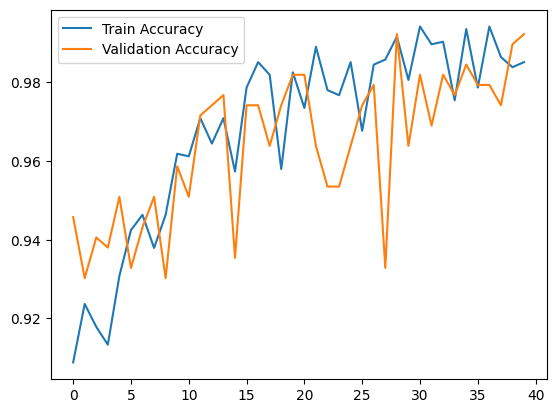

In [35]:
# Avaliação
score = model.evaluate(X_test, y_test_hot)
print(f"Test Loss: {score[0]}, Test Accuracy: {score[1]}")

# Visualizar histórico
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [36]:
# Certifique-se de que o conjunto de teste tem o formato correto
X_test = np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], num_frames, altura, largura, canais))

# Gerar predições
print("Generating test predictions...")
predictions = model.predict(X_test)
print(np.around(predictions, 2))  # Mostra as probabilidades arredondadas para cada classe

# Converter probabilidades em classes preditas
y_pred_class = np.argmax(predictions, axis=1)
y_test_class = np.argmax(y_test_hot, axis=1)  # Certifique-se de que os rótulos reais também estão no formato de classe

# Avaliação do modelo
score = model.evaluate(X_test, y_test_hot, batch_size=32)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Comparar predições com os valores reais e imprimir resultados
for i in range(len(y_test_class)):
    if y_pred_class[i] == y_test_class[i]:
        print(f'\033[92mPredicted: {y_pred_class[i]} (expected: {y_test_class[i]})')
    else:
        print(f'\033[91mPredicted: {y_pred_class[i]} (expected: {y_test_class[i]})')


Generating test predictions...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9925 - loss: 0.0182
Test loss: 0.02220563404262066
Test accuracy: 0.9906976819038391
Predicted: 2 (expected: 2)
Predicted: 6 (expected: 6)
Predicted: 7 (expected: 7)
Predicted: 0 (expected: 0)
Predicted: 1 (expected: 1)
Predicted: 1 (expected: 1)
Predicted: 6 (expected: 6)
Predicted: 1 (expected: 1)
Predicted: 3 (expected: 3)
Predicted: 4 (expected: 4)
Predicted: 7 (expected: 7)
Predicted: 9 (expected: 9)
Predicted: 8 (expected: 8)
Predicted: 6 (expected: 6)
Predicted: 3 (expected: 3)
Predicted: 6 (expected: 6)
Predicted: 6 (expected: 6)
Predicted: 2 (expected: 2)
Predicted: 5 (expected: 5)
Predicted: 2 (expected: 2)
Predicted: 7 (expected: 7)
Predicted: 8 (expected: 8)
Predicted: 4 (expected: 4)
Predicted: 5 (e

In [37]:
model.save(r"D:\ProjetoFinal_VisaoComp\model_mask10classes.keras")

In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Caminho para o modelo treinado e os vídeos com máscaras
model_path = r"D:\ProjetoFinal_VisaoComp\model_mask10classes.keras"
videos_path = r"D:\libras-mask-alunos"

# Carregar o modelo treinado
model = load_model(model_path)

# Função para processar um vídeo com máscara
def process_masked_video(video_path, num_frames=30, altura=64, largura=64):
    cap = cv2.VideoCapture(video_path)
    frames = []
    success, frame = cap.read()
    
    while success:
        # Converter para escala de cinza e redimensionar
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        resized_frame = cv2.resize(gray_frame, (largura, altura))
        frames.append(resized_frame / 255.0)  # Normalização
        success, frame = cap.read()
    
    cap.release()
    
    # Garantir que o número de frames é consistente
    if len(frames) > num_frames:
        indices = np.linspace(0, len(frames) - 1, num_frames).astype(int)
        frames = [frames[i] for i in indices]
    elif len(frames) < num_frames:
        padding = num_frames - len(frames)
        frames.extend([frames[-1]] * padding)
    
    # Converter para formato esperado pelo modelo
    return np.array(frames).reshape(1, num_frames, altura, largura, 1)  # Adicionar batch e canal

# Classificar os vídeos no diretório
print("[INFO] Classifying masked videos...")
for video_file in os.listdir(videos_path):
    if video_file.endswith(('.mp4', '.avi', '.mov')):  # Ajuste as extensões conforme necessário
        video_path = os.path.join(videos_path, video_file)
        
        # Processar o vídeo e realizar a classificação
        input_data = process_masked_video(video_path)
        predictions = model.predict(input_data)
        class_id = np.argmax(predictions)
        
        # Exibir a classe prevista e as probabilidades
        print(f"Video: {video_file} - Predicted Class: {class_id} - Probabilities: {np.around(predictions, 2)}")


[INFO] Classifying masked videos...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Video: mask_acontecer.mp4 - Predicted Class: 0 - Probabilities: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Video: mask_amarelo.mp4 - Predicted Class: 1 - Probabilities: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Video: mask_america.mp4 - Predicted Class: 8 - Probabilities: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Video: mask_aproveitar.mp4 - Predicted Class: 3 - Probabilities: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Video: mask_banheiro.mp4 - Predicted Class: 4 - Probabilities: [[0.06 0.   0.   0.01 0.88 0.   0.   0.   0.   0.05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Video: mask_barulho.mp4 - Predicted Class: 5 - Probabilities: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Video: mask_cinco.mp4 - Predicted Class: 3 - Probabilities: [[0.   0.   0.   0.6  0.   0.19 0. 